In [1]:
from transformers import ViTImageProcessor, ViTForImageClassification
from tqdm import tqdm
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
import torch
import os
import pickle

external_path=''

In [2]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('aaraki/vit-base-patch16-224-in21k-finetuned-cifar10')

In [3]:
dataset = load_dataset("uoft-cs/cifar10")

train_set = dataset["train"]
test_set = dataset["test"]

concepts=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

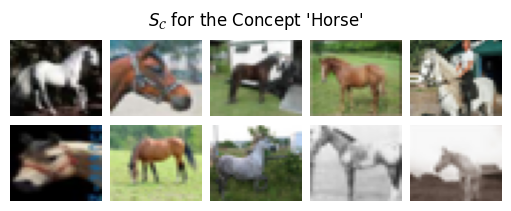

In [4]:
fig,axs=plt.subplots(nrows=2,ncols=5,layout='constrained')
fig.suptitle("$S_{\\mathcal{C}}$ for the Concept 'Horse'")
fig.set_figheight(2)
fig.set_figwidth(5)
count=0
for instance in test_set:
    if instance['label']==7:
        image=np.array(instance['img'])

        axs[count//5,count%5].imshow(image,aspect='auto')
        axs[count//5,count%5].axis('off')
        count+=1
    if count>9:
        break

In [ ]:
progress_bar=tqdm(concepts)
class_test_indices={concept:[] for concept in concepts}
for concept in progress_bar:
    if not(os.path.exists(f'{external_path}\\concept_token_activations\\{concept}')):
        os.mkdir(f'{external_path}\\concept_token_activations\\{concept}')
    
    total_num_instances=0
    acc_count=0

    save_block=1
    concept_token_activations=[]
    first_instance=True
    num_instances=0
    
    for n,test_instance in enumerate(test_set):

        if concepts[test_instance['label']]!=concept:
            continue

        image=np.array(test_instance['img'])

        model_input = processor(images=image, return_tensors="pt")
        model_output = model(**model_input,output_hidden_states=True)
        
        predicted_concept=concepts[model_output.logits.argmax(-1).item()]

        if predicted_concept==concept:

            class_test_indices[concept]+=[n]

            acc_count+=1
            for k, hidden_state in enumerate(model_output.hidden_states):
                if first_instance:
                    concept_token_activations.append(hidden_state[:,0,:].unsqueeze(0))
                else:
                    concept_token_activations[k]=torch.cat([concept_token_activations[k],hidden_state[:,0,:].unsqueeze(0)])
            first_instance=False
        num_instances+=1
        total_num_instances+=1
        progress_bar.set_description(f'Concept {concept}...{total_num_instances}/1000...{acc_count/total_num_instances:.4f}')

        if num_instances==100:
            for layer,activations in enumerate(concept_token_activations):
                torch.save(activations,f'{external_path}\\concept_token_activations\\{concept}\\layer{layer}_{save_block}.pt')

            concept_token_activations=[]
            first_instance=True
            num_instances=0
            save_block+=1

    training_log=open(f'{external_path}\\concept_token_activations\\{concept}\\training_log.txt','w')
    training_log.write(str(acc_count))
    training_log.close()

class_test_indices_file=open(f'{external_path}\\concept_correctly_classified_indices','wb')
pickle.dump(class_test_indices,class_test_indices_file)
class_test_indices_file.close()